In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns

In [5]:
warnings.filterwarnings("ignore")

# plt.style.use("seaborn-darkgrid")

sns.set_context("paper", font_scale=1.4)

BATCH_SIZE = 32

id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

In [6]:
num_classes = len(id_map.keys())

In [7]:
def preprocess(path):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256)).resize((128, 128))
    img2 = img.crop((256, 0, 512, 256)).resize((128, 128))
    img1 = np.array(img1) / 255.
    img2 = np.array(img2)
    mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)
    for row in range(img2.shape[0]):
        for col in range(img2.shape[1]):
            a = img2[row, col, :]
            final_key = None
            final_d = None
            for key, value in id_map.items():
                d = np.sum(np.sqrt(pow(a - value, 2)))
                if final_key == None:
                    final_d = d
                    final_key = key
                elif d < final_d:
                    final_d = d
                    final_key = key
            mask[row, col] = final_key
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
    del img2
    return img1, mask

In [7]:
def prepare_tensor_dataset(train_path, val_path):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    for file in tqdm(os.listdir(train_path)):
        img, mask = preprocess(f"{train_path}/{file}")
        X_train.append(img)
        Y_train.append(mask)
    
    for file in tqdm(os.listdir(val_path)):
        img, mask = preprocess(f"{val_path}/{file}")
        X_val.append(img)
        Y_val.append(mask)

    return X_train, Y_train, X_val, Y_val

In [8]:
X_train, Y_train, X_valid, Y_valid = prepare_tensor_dataset("./data Set/cityscapes_data/train/", "./data Set/cityscapes_data/val/")

  2%|▏         | 68/2975 [02:00<1:25:54,  1.77s/it]

In [8]:
X_train = np.load("./npy_files/X_train.npy")
Y_train = np.load("./npy_files/Y_train.npy")
X_valid = np.load("./npy_files/X_valid.npy")
Y_valid = np.load("./npy_files/Y_valid.npy")

In [9]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

In [10]:
def get_unet_model():
    
    inputs = tf.keras.layers.Input(shape = [128, 128, 3])
    
    #First Downsample
    f1 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(inputs)
    b1 = tf.keras.layers.BatchNormalization()(f1)
    f2 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b1)    # Used later for residual connection
    
    m3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f2)
    d4 = tf.keras.layers.Dropout(0.2)(m3)
    
    # Second Downsample
    f5 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d4)
    b5 = tf.keras.layers.BatchNormalization()(f5)
    f6 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b5)    # Used later for residual connection
    
    m7 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f6)
    d8 = tf.keras.layers.Dropout(0.2)(m7)
    
    # Third Downsample
    f9 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d8)
    b9 = tf.keras.layers.BatchNormalization()(f9)
    f10 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b9)    # Used later for residual connection
    
    m11 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f10)
    d12 = tf.keras.layers.Dropout(0.2)(m11)
    
    #Forth Downsample
    f13 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d12)
    b13 = tf.keras.layers.BatchNormalization()(f13)
    f14 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b13)    # Used later for residual connection
    
    m15 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f14)
    d16 = tf.keras.layers.Dropout(0.2)(m15)
    
    #Fifth Downsample
    f17 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d16)
    b17 = tf.keras.layers.BatchNormalization()(f17)
    f18 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b17)

    
    # First Upsample
    m19 = tf.keras.layers.UpSampling2D(size = (2, 2))(f18)
    d19 = tf.keras.layers.Dropout(0.2)(m19)
    c20 = tf.keras.layers.Concatenate()([d19, f14])
    f21 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(c20)
    b21 = tf.keras.layers.BatchNormalization()(f21)
    f22 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b21)
    
    # Second Upsample
    m23 = tf.keras.layers.UpSampling2D(size = (2, 2))(f22)
    d23 = tf.keras.layers.Dropout(0.2)(m23)
    c24 = tf.keras.layers.Concatenate()([d23, f10])
    f25 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c24)
    b25 = tf.keras.layers.BatchNormalization()(f25)
    f26 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b25)
    
    # Third Upsample
    m27 = tf.keras.layers.UpSampling2D(size = (2, 2))(f26)
    d27 = tf.keras.layers.Dropout(0.2)(m27)
    c28 = tf.keras.layers.Concatenate()([d27, f6])
    f29 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c28)
    b29 = tf.keras.layers.BatchNormalization()(f29)
    f30 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b29)
    
    #Forth Upsample
    m31 = tf.keras.layers.UpSampling2D(size = (2, 2))(f30)
    d31 = tf.keras.layers.Dropout(0.2)(m31)
    c32 = tf.keras.layers.Concatenate()([d31, f2])
    f33 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c32)
    b33 = tf.keras.layers.BatchNormalization()(f33)
    f34 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b33)
    
    # Output Layer
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size = (3, 3), padding = "same", strides = 1, activation = "softmax")(f34)
    
    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    return model

In [11]:
model = get_unet_model()

In [12]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, file_path, **kwargs):
        super().__init__(**kwargs)
        self.file_path = file_path
    
    def on_epoch_end(self, epoch, logs=None):
        img, mask = preprocess(self.file_path)
        img = np.array(img)
        img = np.reshape(img, (1, 128, 128, 3))
        pred = model.predict(img)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 128))
        fig, axes = plt.subplots(nrows = 1, ncols = 2)
        axes[0].imshow(mask)
        axes[0].set_title("Original Mask")
        axes[1].imshow(y_pred)
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

def plot_history(history):
  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
  # Training
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["loss"], ax = axes[0], label="Training Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["accuracy"], ax = axes[1], label="Training Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["mean_iou"], ax = axes[2], label="Training Mean IOU")

  # Validation
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_loss"], ax = axes[0], label="Validation Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_accuracy"], ax = axes[1], label="Validation Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_mean_iou"], ax = axes[2], label="Validation Mean IOU")
  
  axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Loss")

  axes[1].set_title("Accuracy Comparison", fontdict = {'fontsize': 15})
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Accuracy")

  axes[2].set_title("Mean IOU Comparison", fontdict = {'fontsize': 15})
  axes[2].set_xlabel("Epoch")
  axes[2].set_ylabel("Mean IOU")
  plt.tight_layout()
  plt.show()

In [13]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)
viz_callback = VizCallback("./data Set/cityscapes_data/val/106.jpg")

Epoch 1/100
93/93 [==============================] - 31s 210ms/step - loss: 1.1474 - accuracy: 0.6910 - mean_iou: 0.1298 - val_loss: 2.7459 - val_accuracy: 0.4494 - val_mean_iou: 0.0419


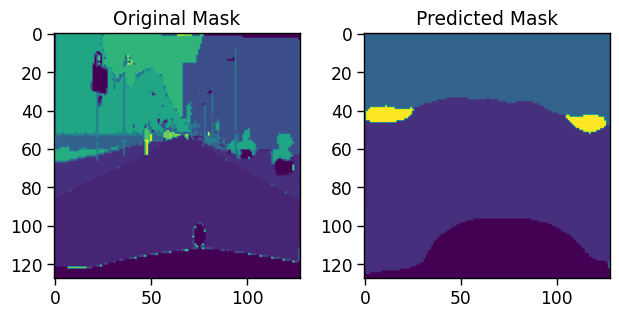

Epoch 2/100
93/93 [==============================] - 14s 145ms/step - loss: 0.8497 - accuracy: 0.7699 - mean_iou: 0.1944 - val_loss: 1.7826 - val_accuracy: 0.5480 - val_mean_iou: 0.0552


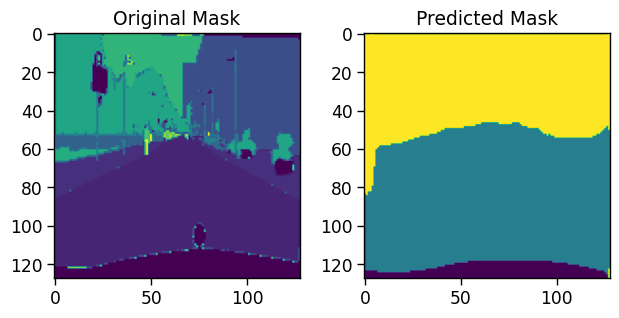

Epoch 3/100
93/93 [==============================] - 14s 146ms/step - loss: 0.7743 - accuracy: 0.7908 - mean_iou: 0.2153 - val_loss: 2.8381 - val_accuracy: 0.4929 - val_mean_iou: 0.0481


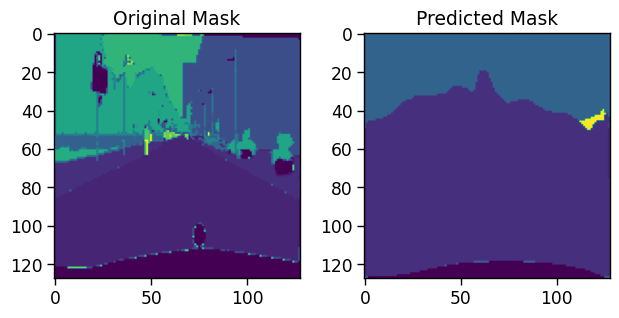

Epoch 4/100
93/93 [==============================] - 14s 147ms/step - loss: 0.7124 - accuracy: 0.8055 - mean_iou: 0.2343 - val_loss: 2.0212 - val_accuracy: 0.4453 - val_mean_iou: 0.0639


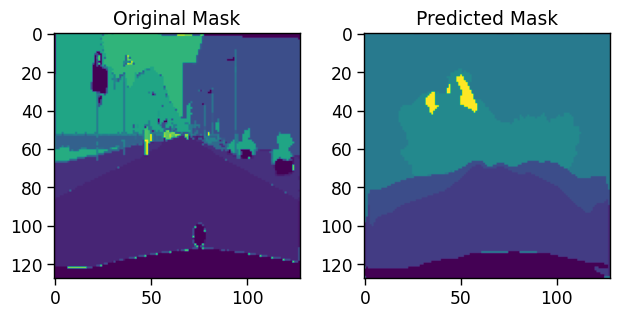

Epoch 5/100
93/93 [==============================] - 14s 147ms/step - loss: 0.6793 - accuracy: 0.8133 - mean_iou: 0.2466 - val_loss: 1.5804 - val_accuracy: 0.6335 - val_mean_iou: 0.0966


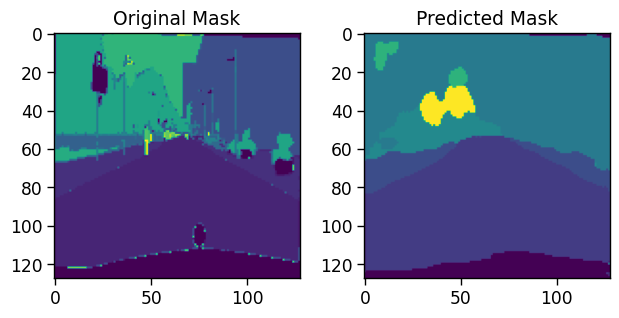

Epoch 6/100
93/93 [==============================] - 14s 147ms/step - loss: 0.6461 - accuracy: 0.8213 - mean_iou: 0.2612 - val_loss: 1.0110 - val_accuracy: 0.7362 - val_mean_iou: 0.1773


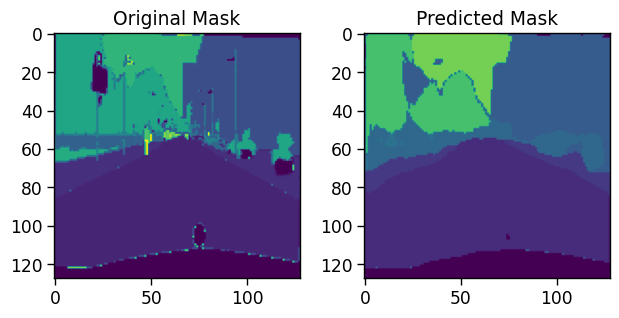

Epoch 7/100
93/93 [==============================] - 14s 147ms/step - loss: 0.6274 - accuracy: 0.8250 - mean_iou: 0.2731 - val_loss: 0.8780 - val_accuracy: 0.7760 - val_mean_iou: 0.2142


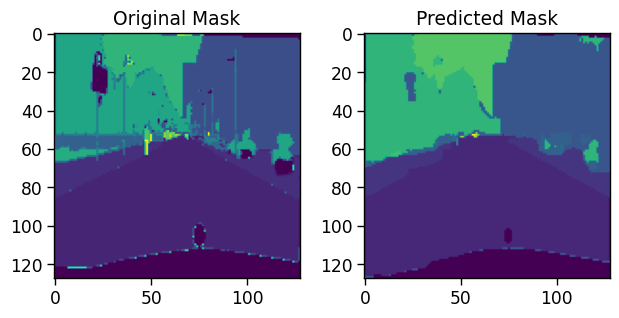

Epoch 8/100
93/93 [==============================] - 14s 147ms/step - loss: 0.6002 - accuracy: 0.8317 - mean_iou: 0.2873 - val_loss: 0.7458 - val_accuracy: 0.7915 - val_mean_iou: 0.2442


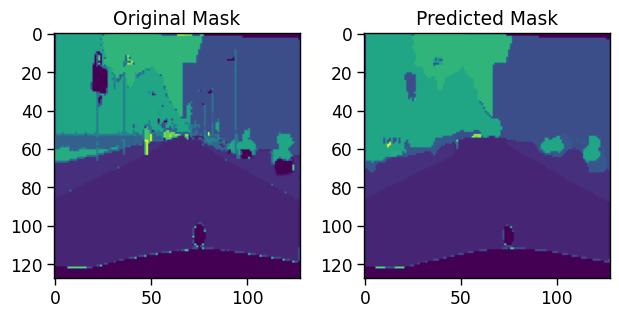

Epoch 9/100
93/93 [==============================] - 14s 146ms/step - loss: 0.5844 - accuracy: 0.8351 - mean_iou: 0.2963 - val_loss: 0.7420 - val_accuracy: 0.7982 - val_mean_iou: 0.2381


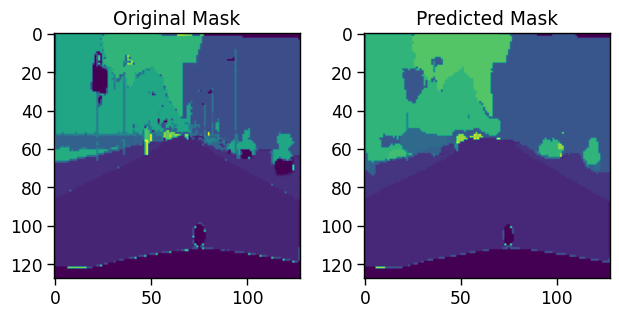

Epoch 10/100
93/93 [==============================] - 14s 147ms/step - loss: 0.5720 - accuracy: 0.8383 - mean_iou: 0.3056 - val_loss: 0.6648 - val_accuracy: 0.8100 - val_mean_iou: 0.2608


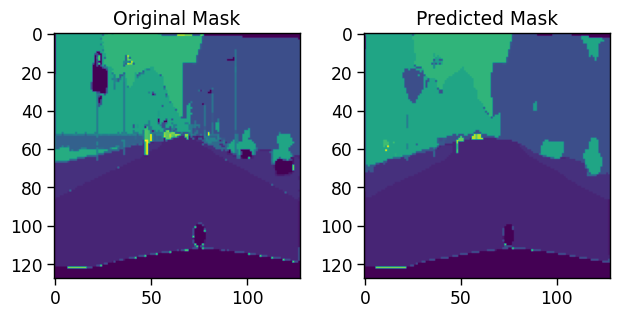

Epoch 11/100
93/93 [==============================] - 14s 147ms/step - loss: 0.5561 - accuracy: 0.8410 - mean_iou: 0.3143 - val_loss: 0.6528 - val_accuracy: 0.8132 - val_mean_iou: 0.2787


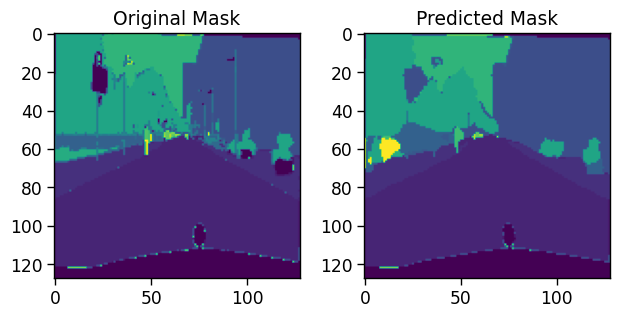

Epoch 12/100
93/93 [==============================] - 14s 146ms/step - loss: 0.5464 - accuracy: 0.8445 - mean_iou: 0.3205 - val_loss: 0.6905 - val_accuracy: 0.8041 - val_mean_iou: 0.2650


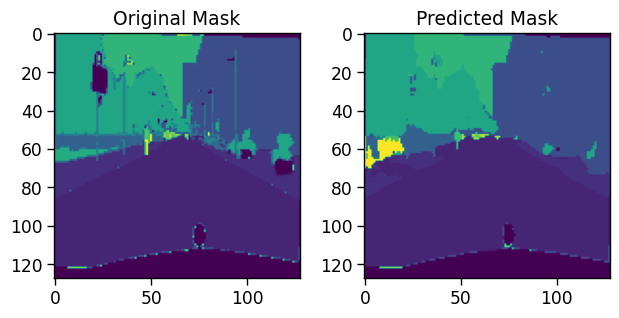

Epoch 13/100
93/93 [==============================] - 14s 148ms/step - loss: 0.5315 - accuracy: 0.8477 - mean_iou: 0.3355 - val_loss: 0.7234 - val_accuracy: 0.8002 - val_mean_iou: 0.2595


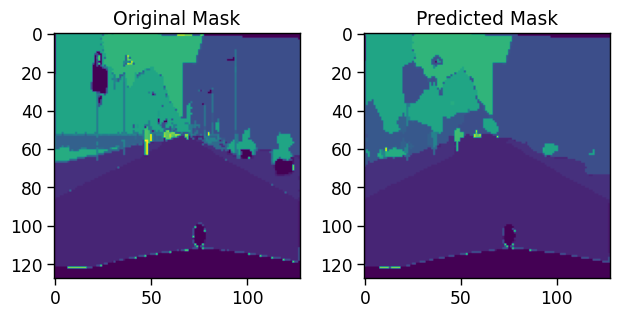

Epoch 14/100
93/93 [==============================] - 14s 147ms/step - loss: 0.5140 - accuracy: 0.8525 - mean_iou: 0.3495 - val_loss: 0.6097 - val_accuracy: 0.8263 - val_mean_iou: 0.2934


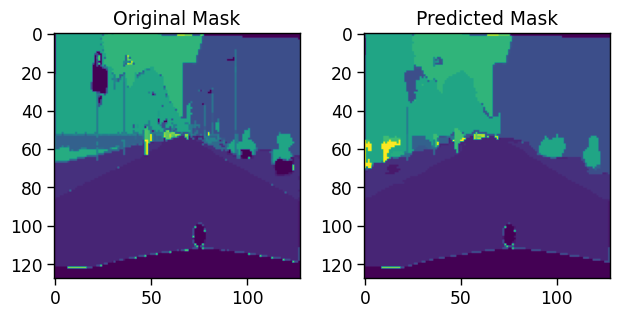

Epoch 15/100
93/93 [==============================] - 14s 147ms/step - loss: 0.4964 - accuracy: 0.8567 - mean_iou: 0.3631 - val_loss: 0.6746 - val_accuracy: 0.8132 - val_mean_iou: 0.2802


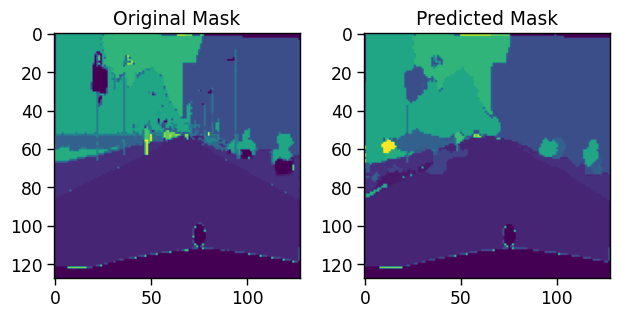

Epoch 16/100
93/93 [==============================] - 14s 146ms/step - loss: 0.4908 - accuracy: 0.8581 - mean_iou: 0.3626 - val_loss: 0.7814 - val_accuracy: 0.7996 - val_mean_iou: 0.2611


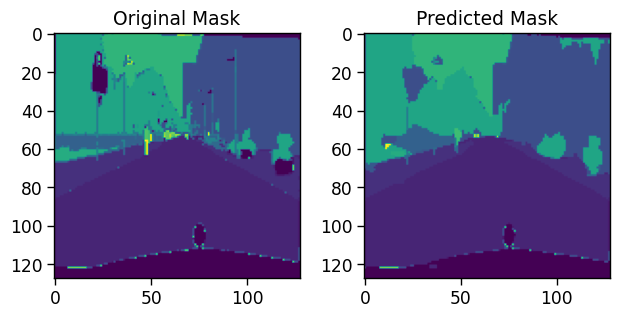

Epoch 17/100
93/93 [==============================] - 14s 146ms/step - loss: 0.4828 - accuracy: 0.8610 - mean_iou: 0.3737 - val_loss: 0.6459 - val_accuracy: 0.8214 - val_mean_iou: 0.2935


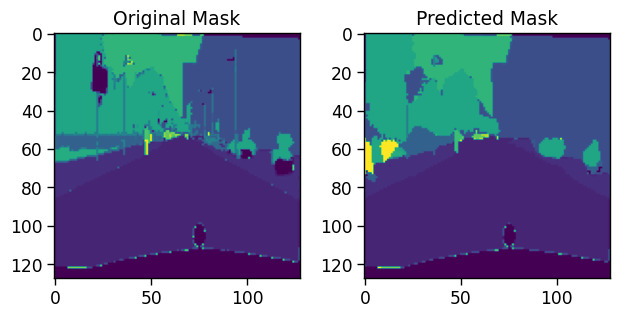

Epoch 18/100
93/93 [==============================] - 14s 147ms/step - loss: 0.4722 - accuracy: 0.8639 - mean_iou: 0.3827 - val_loss: 0.6694 - val_accuracy: 0.8236 - val_mean_iou: 0.2883


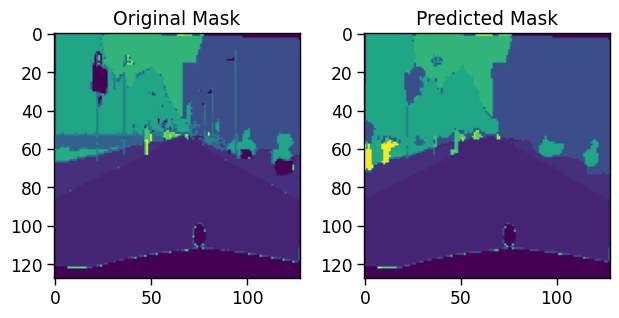

Epoch 19/100
93/93 [==============================] - 14s 147ms/step - loss: 0.4609 - accuracy: 0.8667 - mean_iou: 0.3885 - val_loss: 0.6355 - val_accuracy: 0.8200 - val_mean_iou: 0.2897


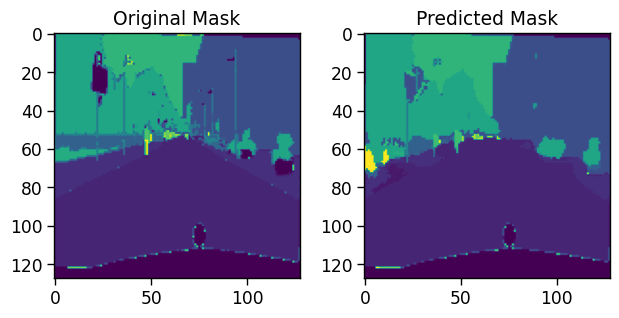

Epoch 20/100
93/93 [==============================] - 14s 147ms/step - loss: 0.4552 - accuracy: 0.8684 - mean_iou: 0.3982 - val_loss: 0.6244 - val_accuracy: 0.8253 - val_mean_iou: 0.2955


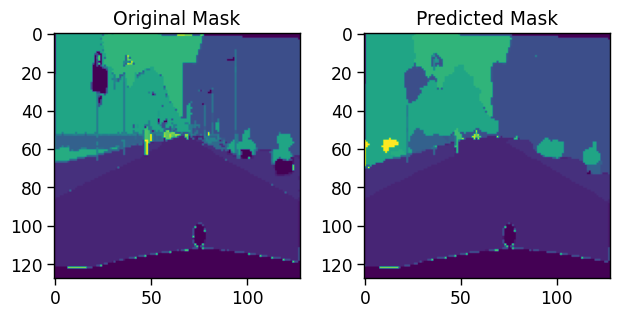

Epoch 21/100
93/93 [==============================] - 14s 146ms/step - loss: 0.4490 - accuracy: 0.8700 - mean_iou: 0.4009 - val_loss: 0.7198 - val_accuracy: 0.8067 - val_mean_iou: 0.2993


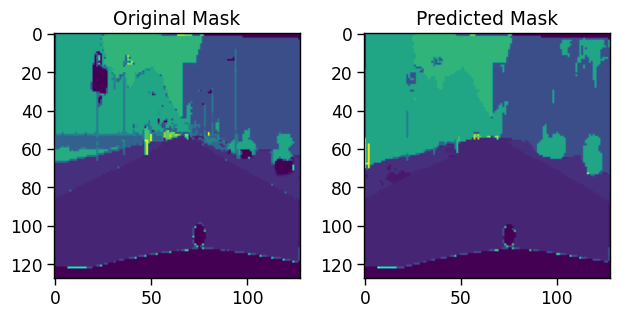

Epoch 22/100
93/93 [==============================] - 14s 147ms/step - loss: 0.4387 - accuracy: 0.8729 - mean_iou: 0.4136 - val_loss: 0.7138 - val_accuracy: 0.8264 - val_mean_iou: 0.2982


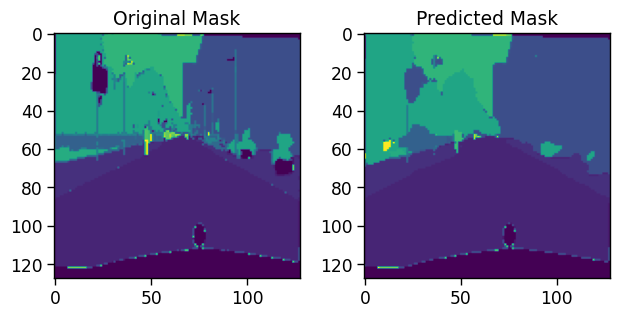

Epoch 23/100
93/93 [==============================] - 14s 146ms/step - loss: 0.4291 - accuracy: 0.8758 - mean_iou: 0.4225 - val_loss: 0.6284 - val_accuracy: 0.8310 - val_mean_iou: 0.3205


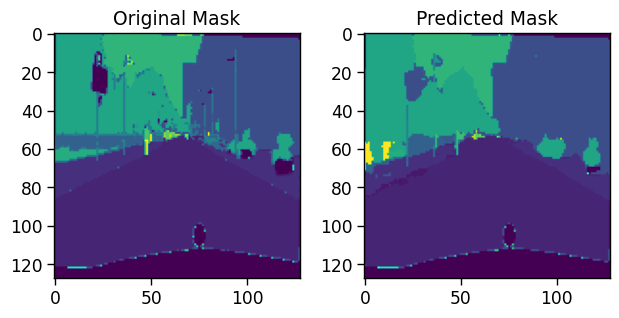

Epoch 24/100
93/93 [==============================] - 14s 147ms/step - loss: 0.4272 - accuracy: 0.8757 - mean_iou: 0.4301 - val_loss: 0.8338 - val_accuracy: 0.8030 - val_mean_iou: 0.2748


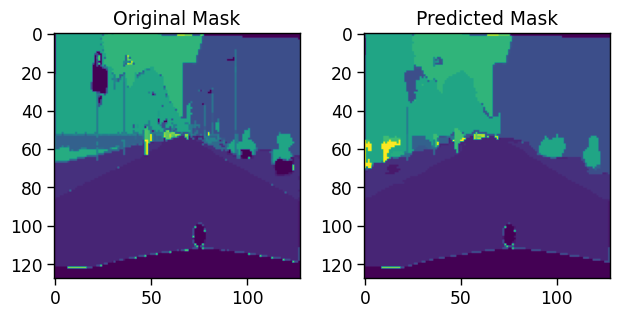

In [15]:
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = 100, validation_data = (X_valid, Y_valid), callbacks = [early_stopping, viz_callback])

In [16]:
model.save("model.h5")

(128, 128, 3) (128, 128, 1)
(128, 128, 3) (128, 128, 1)
(128, 128, 3) (128, 128, 1)


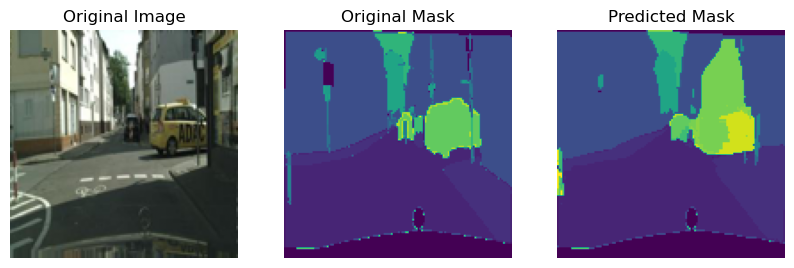

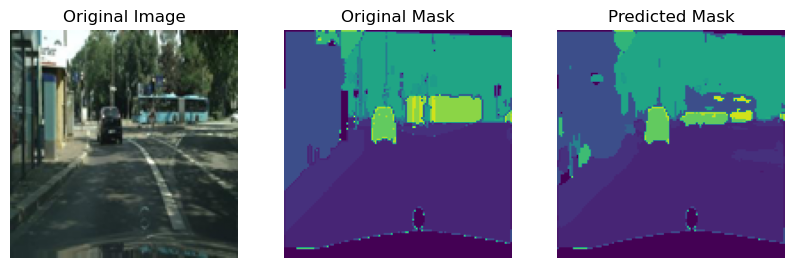

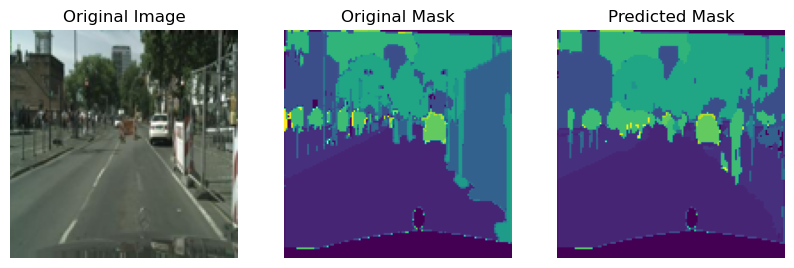

In [42]:
plt.style.use("default")
for i in os.listdir("./data Set/cityscapes_data/val/")[:3]:
    img, mask = preprocess(f"./data Set/cityscapes_data/val/{i}")
    print(img.shape, mask.shape)
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)
    y_pred = tf.math.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="viridis")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="viridis")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

In [70]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import tensorflow as tf
from tqdm import tqdm

# Assume UpdatedMeanIoU is defined in your code
    # Your implementation of UpdatedMeanIoU metric

# 사용자 정의 메트릭 함수를 등록
custom_objects = {'UpdatedMeanIoU': UpdatedMeanIoU}

# 모델 로드 시 custom_objects 매개변수 사용
model = tf.keras.models.load_model("model.h5", custom_objects=custom_objects)



def apply_color_map(mask, id_map):
    # Get the number of classes
    num_classes = len(id_map)

    # Find the index of the class with the highest probability for each pixel
    class_indices = np.argmax(mask, axis=-1)

    # Resize class_indices to match the shape of the frame
    class_indices_resized = cv2.resize(class_indices.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)

    # Create an empty image with shape (1280, 720, 3)
    colored_mask = np.zeros((H, W, 3), dtype=np.uint8)

    # Iterate over each class and assign the corresponding color to the pixels
    for class_id, color in id_map.items():
        # Find the pixels where the class index matches the current class_id
        pixels = class_indices_resized == class_id

        # Assign the color to those pixels in the colored_mask
        colored_mask[pixels] = color

    return colored_mask

if __name__ == "__main__":
    """ Video Path """
    video_path = "paris.mp4"

    """ Reading frames """
    cap = cv2.VideoCapture(video_path)
    _, frame = cap.read()
    H, W, _ = frame.shape

    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    out = cv2.VideoWriter('output.avi', fourcc, 10, (W, H), True)

    # 설정할 시작과 끝 프레임
    start_frame = 600
    end_frame = 2000

    idx = 0
    for i in tqdm(range(end_frame)):
        ret, frame = cap.read()
        if not ret:
            cap.release()
            out.release()
            break

        if i >= start_frame:
            H, W, _ = frame.shape
            ori_frame = frame
            frame = cv2.resize(frame, (128, 128))
            frame = np.expand_dims(frame, axis=0)
            frame = frame / 255.0

            mask = model.predict(frame)[0]

            # Thresholding
            mask = mask > 0.3
            mask = mask.astype(np.uint8)
            mask = cv2.resize(mask, (W, H))

            # colored_mask = np.zeros((H, W, 3), dtype=np.uint8)
            # for class_id, color in id_map.items():
            #     colored_mask += (mask[:, :, class_id] > 0).astype(np.uint8)[:, :, np.newaxis] * np.array(color, dtype=np.uint8)

            # # Combine the colored mask with the original frame
            # combine_frame = ori_frame * (1 - mask[:, :, 0][:, :, np.newaxis]) + colored_mask

            combine_frame = ori_frame * mask[:,:,0:3]

            combine_frame = combine_frame.astype(np.uint8)

            # Save the image
            cv2.imwrite(f"video/{idx}.png", combine_frame)
            idx += 1

            # Write to video output
            out.write(combine_frame)

    out.release()



100%|██████████| 2000/2000 [01:05<00:00, 30.51it/s]


In [65]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import tensorflow as tf
from tqdm import tqdm

# Assume UpdatedMeanIoU is defined in your code
    # Your implementation of UpdatedMeanIoU metric

# 사용자 정의 메트릭 함수를 등록
custom_objects = {'UpdatedMeanIoU': UpdatedMeanIoU}

# 모델 로드 시 custom_objects 매개변수 사용
model = tf.keras.models.load_model("model.h5", custom_objects=custom_objects)



def apply_color_map(mask, id_map):
    # Get the number of classes
    num_classes = len(id_map)

    # Find the index of the class with the highest probability for each pixel
    class_indices = np.argmax(mask, axis=-1)

    # Resize class_indices to match the shape of the frame
    class_indices_resized = cv2.resize(class_indices.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)

    # Create an empty image with shape (1280, 720, 3)
    colored_mask = np.zeros((H, W, 3), dtype=np.uint8)

    # Iterate over each class and assign the corresponding color to the pixels
    for class_id, color in id_map.items():
        # Find the pixels where the class index matches the current class_id
        pixels = class_indices_resized == class_id

        # Assign the color to those pixels in the colored_mask
        colored_mask[pixels] = color

    return colored_mask

if __name__ == "__main__":
    """ Video Path """
    video_path = "paris.mp4"

    """ Reading frames """
    cap = cv2.VideoCapture(video_path)
    _, frame = cap.read()
    H, W, _ = frame.shape

    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    out = cv2.VideoWriter('output.avi', fourcc, 10, (W, H), True)

    # 설정할 시작과 끝 프레임
    start_frame = 600
    end_frame = 2000

    idx = 0
    for i in tqdm(range(end_frame)):
        ret, frame = cap.read()
        if not ret:
            cap.release()
            out.release()
            break

        if i >= start_frame:
            H, W, _ = frame.shape
            ori_frame = frame
            frame = cv2.resize(frame, (128, 128))
            frame = np.expand_dims(frame, axis=0)
            frame = frame / 255.0

            mask = model.predict(frame)[0]

            # Thresholding
            mask = mask > 0.3
            mask = mask.astype(np.uint8)
            mask = cv2.resize(mask, (W, H))

            colored_mask = np.zeros((H, W, 3), dtype=np.uint8)
            for class_id, color in id_map.items():
                colored_mask += (mask[:, :, class_id] > 0).astype(np.uint8)[:, :, np.newaxis] * np.array(color, dtype=np.uint8)

            # Combine the colored mask with the original frame
            combine_frame = ori_frame * (1 - mask[:, :, 0][:, :, np.newaxis]) + colored_mask

            combine_frame = combine_frame.astype(np.uint8)

            # Save the image
            cv2.imwrite(f"video/{idx}.png", combine_frame)
            idx += 1

            # Write to video output
            out.write(combine_frame)

    out.release()



 35%|███▌      | 702/2000 [00:36<01:07, 19.27it/s] 


KeyboardInterrupt: 

In [73]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import tensorflow as tf
from tqdm import tqdm

# Assume UpdatedMeanIoU is defined in your code
# Your implementation of UpdatedMeanIoU metric

# 사용자 정의 메트릭 함수를 등록
custom_objects = {'UpdatedMeanIoU': UpdatedMeanIoU}

# 모델 로드 시 custom_objects 매개변수 사용
model = tf.keras.models.load_model("model.h5", custom_objects=custom_objects)

# 추가된 코드
id_map = {
    0: (0, 0, 0),  # unlabelled
    1: (111, 74, 0),  # static
    2: (81, 0, 81),  # ground
    3: (128, 64, 127),  # road
    4: (244, 35, 232),  # sidewalk
    5: (250, 170, 160),  # parking
    6: (230, 150, 140),  # rail track
    7: (70, 70, 70),  # building
    8: (102, 102, 156),  # wall
    9: (190, 153, 153),  # fence
    10: (180, 165, 180),  # guard rail
    11: (150, 100, 100),  # bridge
    12: (150, 120, 90),  # tunnel
    13: (153, 153, 153),  # pole
    14: (153, 153, 153),  # polegroup
    15: (250, 170, 30),  # traffic light
    16: (220, 220, 0),  # traffic sign
    17: (107, 142, 35),  # vegetation
    18: (152, 251, 152),  # terrain
    19: (70, 130, 180),  # sky
    20: (220, 20, 60),  # person
    21: (255, 0, 0),  # rider
    22: (0, 0, 142),  # car
    23: (0, 0, 70),  # truck
    24: (0, 60, 100),  # bus
    25: (0, 0, 90),  # caravan
    26: (0, 0, 110),  # trailer
    27: (0, 80, 100),  # train
    28: (0, 0, 230),  # motorcycle
    29: (119, 11, 32),  # bicycle
    30: (0, 0, 142)  # license plate
}

category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

def apply_color_map(mask, id_map, selected_channels):
    # Get the number of classes
    num_classes = len(id_map)

    # Find the index of the class with the highest probability for each pixel
    class_indices = np.argmax(mask, axis=-1)

    # Resize class_indices to match the shape of the frame
    class_indices_resized = cv2.resize(class_indices.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)

    # Create an empty image with shape (1280, 720, 3)
    colored_mask = np.zeros((H, W, 3), dtype=np.uint8)

    # Iterate over each class and assign the corresponding color to the pixels
    for class_id, color in id_map.items():
        # Find the pixels where the class index matches the current class_id
        pixels = class_indices_resized == class_id

        # Check if the current class_id is in the selected channels
        if class_id in selected_channels:
            # Assign the color to those pixels in the colored_mask
            colored_mask[pixels] = color

    return colored_mask


if __name__ == "__main__":
    """ Video Path """
    video_path = "paris.mp4"

    """ Reading frames """
    cap = cv2.VideoCapture(video_path)
    _, frame = cap.read()
    H, W, _ = frame.shape

    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    out = cv2.VideoWriter('output.avi', fourcc, 10, (W, H), True)

    # 설정할 시작과 끝 프레임
    start_frame = 700
    end_frame = 1900

    # 선택할 채널 (0번째, 3번째, 22번째)
    selected_channels = [0, 3, 22]

    idx = 0
    for i in tqdm(range(end_frame)):
        ret, frame = cap.read()
        if not ret:
            cap.release()
            out.release()
            break

        if i >= start_frame:
            H, W, _ = frame.shape
            ori_frame = frame
            frame = cv2.resize(frame, (128, 128))
            frame = np.expand_dims(frame, axis=0)
            frame = frame / 255.0

            mask = model.predict(frame)[0]

            # Thresholding
            mask = mask > 0.3
            mask = mask.astype(np.uint8)
            mask = cv2.resize(mask, (W, H))

            # 채널 선택을 적용하여 컬러 맵 생성
            colored_mask = apply_color_map(mask, id_map, selected_channels)

            # Combine the colored mask with the original frame
            combine_frame = ori_frame * (1 - mask[:, :, 0][:, :, np.newaxis]) + colored_mask

            combine_frame = combine_frame.astype(np.uint8)

            # Save the image
            cv2.imwrite(f"video/{idx}.png", combine_frame)
            idx += 1

            # Write to video output
            out.write(combine_frame)

    out.release()


100%|██████████| 1900/1900 [02:49<00:00, 11.20it/s]
